## Module 3 project - Ravi Dahiya & Khairul Omar
### Crime statistics around Moorgate in London

### Table of contents
1. Executive summary
2. Data import and data cleansing  
    - Street crimes data  
    - Police stop and search data  
3. EDA & subsetting for hypothesis  
    - Severity of crimes
    - Seasonality of crimes
    - Status of crime investigation
    - Stop and search by ethnicity
4. Hypothesis tests  
    - Is there a seasonality effect between crime level and month?
    - Is the suspect for violent crimes less likely to be identified than others?
    - Are ethnic minorities more likely to be stopped and searched?
5. Conclusion

### 1. Executive summary

In this study, we looked at 3-year UK Police database on street crime and stop & search conducted by the police in a 1 mile radius around Moorgate, London between Dec 2016 and Nov 2019. Upon analysing the dataset and considering other claims that were made in the media, we proceeded to come up with our own hypothesis tests to investigate the following questions:
1. From the data, there appears to be higher level of crime in the later half of the year compared to the first half. Are the differences in crime level by month statistically significant and what may be the driver behind them?
<br><br>
2. Conviction rate for a crime is a matter of public concern as can shape the public perception on the effectiveness of the police force. Our data seem to suggest that suspect for violent crimes around Moorgate is less likely to be identified than others, but is this true?
<br><br>
3. There has been independent reports that ethnic minorities are generally more likely to be stopped and searched compared to the general population. Would our data around Moorgate come up with the same conclusion?

### 2. Data import and data cleansing
Data from our study is retrieve from UK Police crime database accessible via its API at https://data.police.uk/docs/

In [6]:
# Import libraries

import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from scipy.stats import f_oneway
from scipy.stats  import chisquare
from time import sleep
import folium
import progressbar

We focus our study on the level of crime around 1 mile radius from Flatiron School in Moorgate over 3-year period between Dec 2016 and Nov 2019.

In [7]:
# Coordinates for Moorgate:

lat=51.517094
long=-0.088761

**Data 1**<br>
First set of data covers street crimes recorded in Moorgate:<br>
https://data.police.uk/docs/method/crime-street/

In [160]:
# Retrieve data from UK Police street crime API
# sleep() function added due to the imposed call limits

url = 'https://data.police.uk/api/crimes-street/all-crime?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()

crime_df=pd.DataFrame()
pb = progressbar.ProgressBar()

for date in pb(date_range):
    crime = requests.get(url.format(lat,long,date))
    crime=crime.json()
    crime_df=crime_df.append(crime)
    sleep(1)
    
crime_df.reset_index(drop=True,inplace=True)

100% |########################################################################|


In [161]:
# Save API result locally as csv and preview raw data:

crime_df.to_csv('crime.csv')
crime_df.head(1)

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month
0,anti-social-behaviour,Force,"{'latitude': '51.504648', 'street': {'id': 953...",,None,,53835379,,2016-12


In [162]:
# Split ['location'] dictionary column into latitude and longitude:

crime_df['latitude']  = crime_df['location'].apply(lambda x:x['latitude'])
crime_df['longitude'] = crime_df['location'].apply(lambda x:x['longitude'])

# Split ['outcome_status'] dictionary column into outcome date and status:

crime_df['date_outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x:x['date'])
crime_df['outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x: x['category'])

# Remove unwanted columns:

crime_df = crime_df.drop(columns=['location','location_type','context','outcome_status','persistent_id','id','location_subtype'])

# Preview cleansed dataframe:

crime_df.iloc[500]

category                                        bicycle-theft
month                                                 2016-12
latitude                                            51.515100
longitude                                           -0.085669
date_outcome                                          2016-12
outcome         Investigation complete; no suspect identified
Name: 500, dtype: object

**Data 2**<br>
Second set data covers records on police stop and search:<br>
https://data.police.uk/docs/method/stops-street/

In [18]:
# Retrieve data from UK Police street crime API

url = 'https://data.police.uk/api/stops-street?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()

stopsearch_df=pd.DataFrame()
pb = progressbar.ProgressBar()

for date in pb(date_range):
    stopsearch = requests.get(url.format(lat,long,date))
    stopsearch=stopsearch.json()
    stopsearch_df=stopsearch_df.append(stopsearch)
    
stopsearch_df.reset_index(drop=True,inplace=True)

100% |########################################################################|


In [27]:
# Save API result locally as csv and preview raw data:

stopsearch_df.to_csv('stopsearch.csv')
stopsearch_df.head(1)

,age_range,outcome,involved_person,self_defined_ethnicity,gender,legislation,outcome_linked_to_object_of_search,datetime,removal_of_more_than_outer_clothing,outcome_object,location,operation,officer_defined_ethnicity,type,operation_name,object_of_search
0,over 34,Suspect arrested,True,White - White British (W1),Male,Misuse of Drugs Act 1971 (section 23),True,2016-12-02T23:20:00+00:00,False,"{'id': 'arrest', 'name': 'Suspect arrested'}","{'latitude': '51.525800', 'street': {'id': 148...",None,White,Person search,None,Controlled drugs


In [44]:
# Split ['location'] dictionary column into latitude and longitude:

stopsearch_df['latitude'] = stopsearch_df['location'].apply(lambda x:x['latitude'])
stopsearch_df['longitude'] = stopsearch_df['location'].apply(lambda x:x['longitude'])

# Split ['outcome_object'] dictionary column into outcome name:

stopsearch_df['outcome_name'] = stopsearch_df[~stopsearch_df['outcome_object'].isna()]['outcome_object'].apply(lambda x: x['name'])

In [45]:
# Preview ethnicity to combine into categories:

stopsearch_df['self_defined_ethnicity'].unique()[17:20]

array(['Chinese or other ethnic group - Chinese (O1)',
       'White - English/Welsh/Scottish/Northern Irish/British',
       'Black/African/Caribbean/Black British - African'], dtype=object)

In [47]:
# Select only the first word in ethnicity to combine groups and reassign minor categories:

stopsearch_df['self_defined_ethnicity'] = stopsearch_df['self_defined_ethnicity'].apply(lambda x:re.split('/|,| ',str(x))[0])
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].isin(['Not','None']),'self_defined_ethnicity']='Other'
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].str.startswith('Chinese'),'self_defined_ethnicity']='Asian'

In [48]:
# Select relevant columns and preview cleansed data:

stopsearch_df = stopsearch_df[['age_range','involved_person','self_defined_ethnicity',
               'gender','datetime','officer_defined_ethnicity','object_of_search','latitude',
              'longitude','outcome_name']]

stopsearch_df.head(1)

,age_range,involved_person,self_defined_ethnicity,gender,datetime,officer_defined_ethnicity,object_of_search,latitude,longitude,outcome_name
0,over 34,True,White,Male,2016-12-02T23:20:00+00:00,White,Controlled drugs,51.525800,-0.087601,Suspect arrested


### 3. EDA & subsetting for hypothesis

**Severity of crimes**<br><br>
For types of crime, we have the option of either treating them as categorical variables or assign numerical values to them for further meaningful analysis. We chose the latter and assign weights to each crime category based on the severity index published by Office of National Statistics (ONS). For example, ONS assigns a severity of 800 for robbery (as a serious crime) while shopliffting gets severity index of 12 (less serious crime):<br>
https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/crimeseverityscoreexperimentalstatistics

In [179]:
# Assign severity index values to each crime category

crime_df['crime_severity'] = crime_df['category'].map({'anti-social-behaviour': 5,'bicycle-theft': 15,
                                                       'burglary': 465, 'criminal-damage-arson': 442,
                                                       'drugs': 9, 'other-theft': 37,
                                                       'possession-of-weapons': 71, 'public-order': 73,
                                                       'robbery': 800, 'shoplifting': 12,
                                                       'theft-from-the-person': 80, 'vehicle-crime': 9,
                                                       'violent-crime': 1447, 'other-crime': 5})

**Seasonality of crimes**<br><br>
Using the index above and the number of reported cases, we could then assess the level of overall crime around Moorgate. We'll first see if there is a seasonality effect between the level of crime and month.

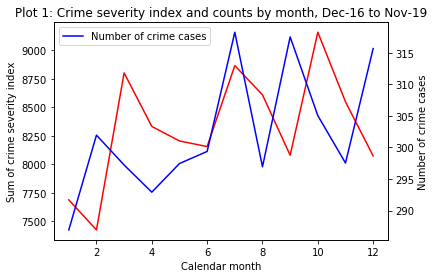

In [170]:
# Visualize the severity of crimes and number of crimes by month

crime_df['crime_month'] = pd.DatetimeIndex(crime_df['month']).month
crime_severity = crime_df.groupby('crime_month')['crime_severity'].count()
crime_count = crime_df.groupby('crime_month')['crime_severity'].mean()

fig, ax1 = plt.subplots()
ax1.plot(crime_severity, c='r', label='Sum of crime severity')
ax1.set_ylabel('Sum of crime severity index')
ax1.set_xlabel('Calendar month')
ax2 = ax1.twinx()
ax2.plot(crime_count, c='b', label='Number of crime cases')
ax2.set_ylabel('Number of crime cases')
ax2.set_title('Plot 1: Crime severity index and counts by month, Dec-16 to Nov-19')
plt.legend()
plt.show()

**Status of crime investigation**<br><br>
There has also been concerns that convinction rates may not be as high as expected, an example of this is highlighted in the following news report: https://www.independent.co.uk/news/uk/crime/crime-statistics-uk-justice-prosecution-rates-rape-victims-disclosure-police-funding-a8747191.html
<br><br>
We wish to investigate the prevalence of where no suspect is identified for reported crimes. This would be particularly concerning for serious crimes where the suspect may still be at large.

In [171]:
# Top 10 investigation status and % of sample:

crime_df['outcome'].value_counts(normalize=True)[0:10]

Status update unavailable                        0.495841
Investigation complete; no suspect identified    0.288931
Under investigation                              0.099159
Unable to prosecute suspect                      0.020793
Court result unavailable                         0.019415
Local resolution                                 0.014369
Offender given a caution                         0.010942
Awaiting court outcome                           0.009971
Offender given a drugs possession warning        0.008761
Offender sent to prison                          0.005980
Name: outcome, dtype: float64

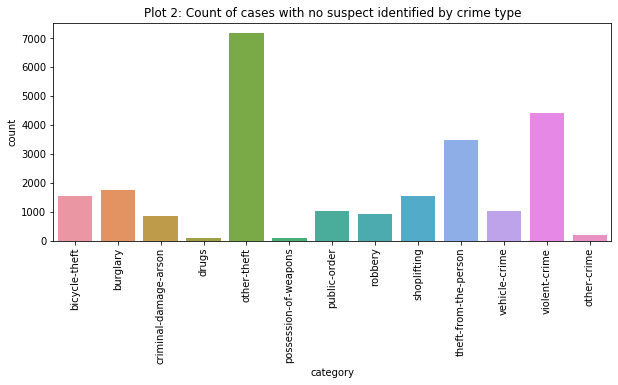

In [172]:
# Subset only cases where no suspect is identified (29% of our data)

no_suspect = crime_df[crime_df['outcome']=='Investigation complete; no suspect identified']

plt.figure(figsize=(10,4))
sns.countplot(no_suspect['category']).set_title('Plot 2: Count of cases with no suspect identified by crime type')
plt.xticks(rotation=90)
plt.show()

**Stop and search by ethnicity**<br><br>
There has been news reports that certain ethnicities are more likely to be unjustifiably stopped for searching by the Police. Our second set of data contains ethnicity information wish we could explore. Futher information about concerns on racial profiling can be found here:
https://www.libertyhumanrights.org.uk/human-rights/justice-and-fair-trials/stop-and-search/stop-and-search-what-you-need-know

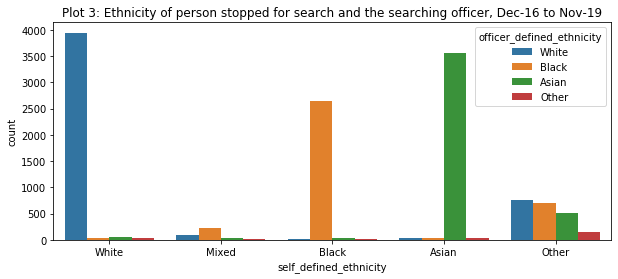

In [173]:
# Plot ethnicity information

plt.figure(figsize=(10,4))
sns.countplot(data=stopsearch_df, x='self_defined_ethnicity',
              hue='officer_defined_ethnicity').set_title('Plot 3: Ethnicity of person stopped for search and the searching officer, Dec-16 to Nov-19')
plt.show()

### 4. Hypothesis tests

**Test 1: Is there a seasonality effect between crime level and month?**
<br><br>
The plot of crime level vs. month shown in the previous section (Plot 1) shows that there appears to be more crimes in the early months of the year compared to the later months. This potential seasonality effect can be explored more based the following subsetting of data:
- Temperature: does temperature affect crime rate around Moorgate? Jan being the coldest month and Jul being the warmest.
- Business activity: as a financial centre with small local population, Moorgate activity is less during holiday periods (Easter, peak summer, Christmas and New Year). Are there more crimes during busier months?

Our hypotheses are as follows:
- H0:
- H1:

The most suited test for our hypotheses would be one-way Anova:

In [178]:
# Categorize months based on temperature:

cold_months     = [1,2,11,12]
mid_temp_months = [3,4,9,10]
warm_months     = [5,6,7,8]

f_oneway(list(crime_df[crime_df['crime_month'].isin(cold_months)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(mid_temp_months)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(warm_months)]['crime_severity']))

F_onewayResult(statistic=0.26495040072741716, pvalue=0.7672445427166527)

In [175]:
# Categorize months based on business activity:

holiday_seasons = [1,4,6,7,12]
regular_seasons = [2,3,5,8,9,10,11]

f_oneway(list(crime_df[crime_df['crime_month'].isin(holiday_seasons)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(regular_seasons)]['crime_severity']))

F_onewayResult(statistic=0.12211839862312619, pvalue=0.7267489127937097)

In [176]:
# Categorize months based on season:

spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]

f_oneway(list(crime_df[crime_df['crime_month'].isin(spring)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(summer)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(autumn)]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin(winter)]['crime_severity']))

F_onewayResult(statistic=2.169319628630795, pvalue=0.08935620196776364)

In [177]:
# Categorize month by ???

f_oneway(list(crime_df[crime_df['crime_month'].isin([3,4,5,6])]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin([7,8,9,10])]['crime_severity']),
         list(crime_df[crime_df['crime_month'].isin([11,12,1,2])]['crime_severity']))

F_onewayResult(statistic=5.43669040155633, pvalue=0.0043551567917107)

Write conclusions here XXXXXXXXXXX

**Test 2: Is the suspect for violent crimes less likely to be identified?**
<br><br>
From the first bar chart shown earlier (Plot 2), we noted that violent crime comes only second after other thefts in terms of number of cases where the suspect is not identified after investigation is completed. We therefore want to investigate this further, to see if serious crimes have a lower rate of suspect identification compared to other crimes.
<br><br>
Our hypotheses are as follows:
- H0: Suspect of violent crimes are equally likely to be identified after investigation is completed as other crimes.
- H1: Suspect of violent crimes are less likely to be identified after investigation is completed.

In [165]:
# Define cut off points for crime severity index to be considered as serious:

mask1 = crime_df['crime_severity'] > 400
mask2 = crime_df['outcome'] =='Investigation complete; no suspect identified'

In [166]:
# Create subsets of 4 samples in chi-square test matrix:

a1 = len(crime_df[ mask1 &  mask2]) # Serious crimes, no suspect identified
a2 = len(crime_df[~mask1 &  mask2]) # Lesser crimes,  no suspect identified
a3 = len(crime_df[ mask1 & ~mask2]) # Serious crimes, other investigation outcomes
a4 = len(crime_df[~mask1 & ~mask2]) # Lesser crimes,  other investigation outcomes

serious_rate = a1/(a1+a3)
lesser_rate  = a2/(a2+a4)

print(f'Serious crimes with no suspect: {round(serious_rate*100,1)}%\nLesser crimes with no suspect: {round(lesser_rate*100,1)}%')

f_obs = np.array([[a1,a2],[a3,a4]])
display(f_obs)

Serious crimes with no suspect: 30.8%
Lesser crimes with no suspect: 21.8%


array([[ 7943, 16166],
       [17858, 57975]])

In [167]:
# Run chi-square test:

chisquare(f_obs)

Power_divergenceResult(statistic=array([ 3810.20987559, 23576.59703808]), pvalue=array([0., 0.]))

With p-value of pratically zero, we can conclude that it is statistically signifcant that the suspect for serious crimes is less likely to be identified compared to lesser crimes comitted around Moorgate based on 2017-2019 data.

**Test 3: Are ethnic minorities more likely to be stopped and searched?**
<br><br>
From Plot 3 earlier we noted that the number of ethnic Asians that were stopped and searched was only slightly lower than ethnic white, although the proportion of ethnic white in the general population is far higher. We want to see if our data around Moorgate supports the claims from some organizations that ethnic minorities are more likely to be stopped and searched. Our hypotheses are as follows:
- H0: Ethnic minorities are no more likely to be stopped and searched than the general population
- H1: Ethnic minorities are more likely to be stopped and searched than the general population

The most suited test for our categorical data is the chi-squared in order to test if the prevalence of stop and search by ethnicity is significantly different from their overall demographic composition. The expected value is taken from 2011 UK National Census for London https://www.nomisweb.co.uk/census/2011/QS201EW/view/2013265927?cols=measures

In [182]:
# Observed % stop and search by ethnicity:

a1 = len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='White'])/len(stopsearch_df)*100
a2 = len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Black'])/len(stopsearch_df)*100
a3 = len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Asian'])/len(stopsearch_df)*100
a4 = len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Mixed'])/len(stopsearch_df)*100
a5 = len(stopsearch_df[stopsearch_df['self_defined_ethnicity']=='Other'])/len(stopsearch_df)*100

f_obs = np.array([a1,a2,a3,a4,a5])
f_obs.round(2)

array([30.95, 20.47, 27.78,  3.  , 17.8 ])

In [180]:
# Expected values % based on national census:

e1 = 59.79 # White
e2 = 13.32 # Black
e3 = 18.49 # Asian
e4 =  4.96 # Mixed
e5 =  3.44 # Other

f_exp = np.array([e1,e2,e3,e4,e5])
f_exp

array([59.79, 13.32, 18.49,  4.96,  3.44])

In [129]:
# Run chi-square test

chisquare(f_obs,f_exp)

Power_divergenceResult(statistic=83.13425013318805, pvalue=3.773125705712949e-17)

With p-values very close to zero, we can conclude that it is statistically signifcant that ethnic minorities are more likely to be stopped and searched around Moorgate based on 2017-2019 data.

### 5. Conclusion

Text